# Importing Dependencies 

In [1]:

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import RMSprop
import numpy as np
import random
import sys


In [2]:
#Loading the text
filename = "/content/chankya neeti.txt"
raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()
print(raw_text[0:1000])

“1.1 सर्वशक्तिमान तीनो लोको के स्वामी श्री विष्णु भगवान को शीश नवाकर मै अनेक शास्त्रों से निकाले गए राजनीति सार के तत्व को जन कल्याण हेतु समाज के सम्मुख रखता हूं”
“1.2 इस राजनीति शास्त्र का विधिपूर्वक अध्ययन करके यह जाना जा सकता है कि कौनसा कार्य करना चाहिए और कौनसा कार्य नहीं करना चाहिए। यह जानकर वह एक प्रकार से धर्मोपदेश प्राप्त करता है कि किस कार्य के करने से अच्छा परिणाम निकलेगा और किससे बुरा। उसे अच्छे बुरे का ज्ञान हो जाता है”
“1.3 इसलिए जनता की भलाई के लिए, मैं वह बात कहूंगा, जो जब समझ में आएगी, तब उनके उचित परिप्रेक्ष्य में चीजों की समझ पैदा होगी”
“1.4 यहां तक ​​कि एक पंडित एक मूर्ख शिष्य को निर्देश देता है, एक दुष्ट पत्नी को बनाए रखने से, और दुखी के साथ अत्यधिक परिचित होने से”
“1.5 दुष्ट स्त्री, छल करने वाला मित्र, पलटकर कर तीखा जवाब देने वाला नौकर तथा जिस घर में सांप रहता हो, उस घर में निवास करने वाले गृहस्वामी की मौत में संशय न करे। वह निश्चित मृत्यु को प्राप्त होता है। – चाणक्य नीति”
“1.6 विपत्ति के समय काम आने वाले धन की रक्षा करे। धन से स्त्री की रक्षा करे और अपनी रक्षा ध

# Pre-Processing

In [3]:
#CLEAN TEXT
#Remove numbers
raw_text = ''.join(c for c in raw_text if not c.isdigit())

#How many total characters do we have in our training text?
chars = sorted(list(set(raw_text))) #List of every character

#Character sequences must be encoded as integers. 
#Each unique character will be assigned an integer value. 
#Create a dictionary of characters mapped to integer values
char_to_int = dict((c, i) for i, c in enumerate(chars))

#Do the reverse so we can print our predictions in characters and not integers
int_to_char = dict((i, c) for i, c in enumerate(chars))

# Data Exploration

In [4]:
# summarize the data
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters in the text; corpus length: ", n_chars)
print("Total Vocab: ", n_vocab)


Total Characters in the text; corpus length:  45245
Total Vocab:  79


In [5]:
from re import X
#Now that we have characters we can create input/output sequences for training
#Remember that for LSTM input and output can be sequences... hence the term seq2seq


seq_length = 60  #Length of each input sequence
step = 10   #Instead of moving 1 letter at a time, here we are trying to skipping a few. 
sentences = []    # X values (Sentences)
next_chars = []   # Y values. The character that follows the sentence defined as X
for i in range(0, n_chars - seq_length, step):  #step=1 means each sentence is offset just by a single letter
    sentences.append(raw_text[i: i + seq_length])  #Sequence in
    next_chars.append(raw_text[i + seq_length])  #Sequence out
n_patterns = len(sentences)    
print('Number of sequences:', n_patterns)



Number of sequences: 4519


Just like time series, X is the sequence / sentence and y is the next value that comes after the sentence... 
reshape input to be [samples, time steps, features]
time steps = sequence length, features = numbers of characters in our vocab (n_vocab)
Vectorize all sentences: there are n_patterns sentences.
For each sentence we have n_vocab characters available for seq_length
Vectorization returns a vector for all sentences indicating the presence or absence of a character. 

In [6]:
x = np.zeros((len(sentences), seq_length, n_vocab), dtype=np.bool)
y = np.zeros((len(sentences), n_vocab), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_to_int[char]] = 1
    y[i, char_to_int[next_chars[i]]] = 1
    
print(x.shape)
print(y.shape)

#print(y[0:10]) commenting this because it will take too much space it is like one hot encoding for first 10 charecters

<ipython-input-6-07e6c2a1329d>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.zeros((len(sentences), seq_length, n_vocab), dtype=np.bool)
<ipython-input-6-07e6c2a1329d>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.zeros((len(sentences), n_vocab), dtype=np.bool)


(4519, 60, 79)
(4519, 79)


# Single LSTM

In [7]:
#Basic model with one LSTM
# build the model: a single LSTM

model = Sequential()
model.add(LSTM(128, input_shape=(seq_length, n_vocab)))
model.add(Dense(n_vocab, activation='softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               106496    
                                                                 
 dense (Dense)               (None, 79)                10191     
                                                                 
Total params: 116,687
Trainable params: 116,687
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
# define the checkpoint
from keras.callbacks import ModelCheckpoint

filepath="saved_weights/saved_weights-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]


# Fit the model

history = model.fit(x, y,
          batch_size=128,
          epochs=60,   
          callbacks=callbacks_list)

model.save('my_saved_weights_hindi_60epochs.h5')

Epoch 1/60
33/36 [==========================>...] - ETA: 0s - loss: 3.4910
Epoch 1: loss improved from inf to 3.46150, saving model to saved_weights/saved_weights-01-3.4615.hdf5
36/36 [==============================] - 7s 11ms/step - loss: 3.4615
Epoch 2/60
29/36 [=======================>......] - ETA: 0s - loss: 2.8756
Epoch 2: loss improved from 3.46150 to 2.85099, saving model to saved_weights/saved_weights-02-2.8510.hdf5
36/36 [==============================] - 0s 8ms/step - loss: 2.8510
Epoch 3/60
32/36 [=========================>....] - ETA: 0s - loss: 2.5203
Epoch 3: loss improved from 2.85099 to 2.50942, saving model to saved_weights/saved_weights-03-2.5094.hdf5
36/36 [==============================] - 0s 7ms/step - loss: 2.5094
Epoch 4/60
33/36 [==========================>...] - ETA: 0s - loss: 2.3287
Epoch 4: loss improved from 2.50942 to 2.32549, saving model to saved_weights/saved_weights-04-2.3255.hdf5
36/36 [==============================] - 0s 7ms/step - loss: 2.3255
Epo

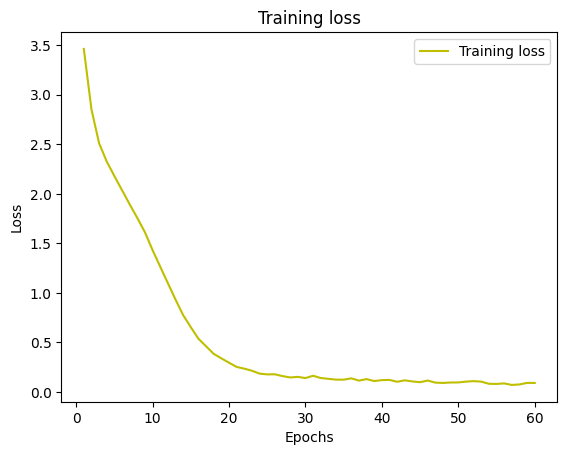

In [9]:
#Tracking loos function 
from matplotlib import pyplot as plt
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
#Generate characters 
#We must provide a sequence of seq_lenth as input to start the generation process
#The prediction results is probabilities for each of the 103 characters at a specific
#point in sequence. Let us pick the one with max probability and print it out.
#Writing our own softmax function....
def sample(preds):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds) #exp of log (x), isn't this same as x??
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1) 
    return np.argmax(probas)


In [11]:
#Prediction
#setting the seed
# load the network weights
filename = "my_saved_weights_hindi_60epochs.h5"
model.load_weights(filename)

#Pick a random sentence from the text as seed.
start_index = random.randint(0, n_chars - seq_length - 1)

#Initiate generated text and keep adding new predictions and print them out
generated = ''
sentence = raw_text[start_index: start_index + seq_length]
generated += sentence

print('----- Seed for our text prediction: "' + sentence + '"')
#sys.stdout.write(generated)

----- Seed for our text prediction: "ै।
.: अभ्यास में नहीं लगाए गए शास्त्रों के पाठ जहर हैं; भोजन"


In [12]:
# predicting the next 400 charecters
for i in range(400):   # Number of characters including spaces
    x_pred = np.zeros((1, seq_length, n_vocab))
    for t, char in enumerate(sentence):
        x_pred[0, t, char_to_int[char]] = 1.

    preds = model.predict(x_pred, verbose=0)[0]
    next_index = sample(preds)
    next_char = int_to_char[next_index]

    generated += next_char
    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()
print()


 उसके लोगो सब में यदि बुदुष्य टाथ यह मरने वृ व्यक्ति  पाए एक एक बलत्रुण जो डपने पर्ता है, उसका ब्रभी भी निश मेश नोीं ौन|”
“.:बादा रोज्यान प फवान रो कुम फर धन होते है|”
“.:विसे सब बचयलग की मऔर मनिसे विल कर्ण से मालता है. यह भो वहीर हो जल मने परता है, उसकी अपने स्वबश्ति को होती और उसका मिव्य मभू धन उती भाए दिसबे सब गुव्या शरे को में मेन मनुश नहीं पढिया उसके अपनी प्तब राणान करे. ए. एक धिसी पर्बशते सी


#Stacked LSTM 


In [13]:
# Deeper model woth 2 LSTM
#To stack LSTM layers, we need to change the configuration of the prior 
#LSTM layer to output a 3D array as input for the subsequent layer.
#We can do this by setting the return_sequences argument on the layer to True 
#(defaults to False). This will return one output for each input time step and provide a 3D array.
#Below is the same example as above with return_sequences=True.

model = Sequential()
model.add(LSTM(128, input_shape=(seq_length, n_vocab), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(n_vocab, activation='softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 60, 128)           106496    
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 79)                10191     
                                                                 
Total params: 248,271
Trainable params: 248,271
Non-trainable params: 0
_________________________________________________________________


In [14]:
# define the checkpoint
from keras.callbacks import ModelCheckpoint

filepath="saved_weights/saved_weights2-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]


# Fit the model

history2 = model.fit(x, y,
          batch_size=128,
          epochs=60,   
          callbacks=callbacks_list)

model.save('my_saved_weights_hindi2_60epochs.h5')

Epoch 1/60
36/36 [==============================] - ETA: 0s - loss: 3.6786
Epoch 1: loss improved from inf to 3.67862, saving model to saved_weights/saved_weights2-01-3.6786.hdf5
36/36 [==============================] - 4s 18ms/step - loss: 3.6786
Epoch 2/60
34/36 [===========================>..] - ETA: 0s - loss: 3.2084
Epoch 2: loss improved from 3.67862 to 3.20377, saving model to saved_weights/saved_weights2-02-3.2038.hdf5
36/36 [==============================] - 1s 23ms/step - loss: 3.2038
Epoch 3/60
36/36 [==============================] - ETA: 0s - loss: 2.7971
Epoch 3: loss improved from 3.20377 to 2.79708, saving model to saved_weights/saved_weights2-03-2.7971.hdf5
36/36 [==============================] - 1s 25ms/step - loss: 2.7971
Epoch 4/60
35/36 [============================>.] - ETA: 0s - loss: 2.5529
Epoch 4: loss improved from 2.79708 to 2.55014, saving model to saved_weights/saved_weights2-04-2.5501.hdf5
36/36 [==============================] - 1s 28ms/step - loss: 2.5

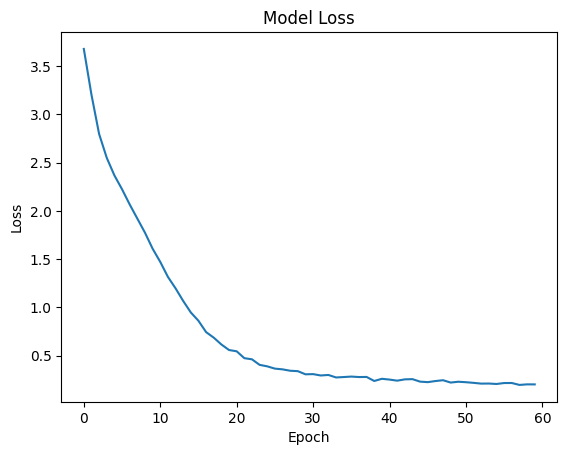

In [18]:
#Tracking loos function 
import matplotlib.pyplot as plt

# Get the loss values from the training history
loss = history2.history['loss']

# Create a plot of the loss over epochs
plt.plot(loss)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [20]:
#Generate characters 
#We must provide a sequence of seq_lenth as input to start the generation process
#The prediction results is probabilities for each of the 103 characters at a specific
#point in sequence. Let us pick the one with max probability and print it out.
#Writing our own softmax function....
def sample(preds):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds) #exp of log (x), isn't this same as x??
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1) 
    return np.argmax(probas)


In [21]:
#Prediction
#setting the seed
# load the network weights
filename = "my_saved_weights_hindi2_60epochs.h5"
model.load_weights(filename)

#Pick a random sentence from the text as seed.
start_index = random.randint(0, n_chars - seq_length - 1)

#Initiate generated text and keep adding new predictions and print them out
generated = ''
sentence = raw_text[start_index: start_index + seq_length]
generated += sentence

print('----- Seed for our text prediction: "' + sentence + '"')
#sys.stdout.write(generated)

----- Seed for our text prediction: " माता है. अध्यात्मिक ज्ञान मेरा पिता है. धर्माचरण मेरा बंधू "


In [22]:
# predicting the next 400 charecters
for i in range(400):   # Number of characters including spaces
    x_pred = np.zeros((1, seq_length, n_vocab))
    for t, char in enumerate(sentence):
        x_pred[0, t, char_to_int[char]] = 1.

    preds = model.predict(x_pred, verbose=0)[0]
    next_index = sample(preds)
    next_char = int_to_char[next_index]

    generated += next_char
    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()
print()


है. वही सुव्वव्म्रे को लोगा की अपनी आत्वति से में तक उसका लाण वन्ह्रण को ता प
रे समला है. धर सोश बदल जो समयक गन कररे वाले वाली के भाजन समें आप उनकी उसकर मिलकत जब फदट भी शरी से माधन से उसकूर वह शरण जो चालण जो मिमेष है की बार इसही अत्योिशि को प्रत्रि को सहैववही से प्रद्यि है.इल की अपनी भोजी को अपनी स्वच्कि से छाश मानि को अपनी प्राप्ति को भी फी शत्ति सा पुण वह एक ला पाआज आपक्रा भी भदी है, मे सकता हो 


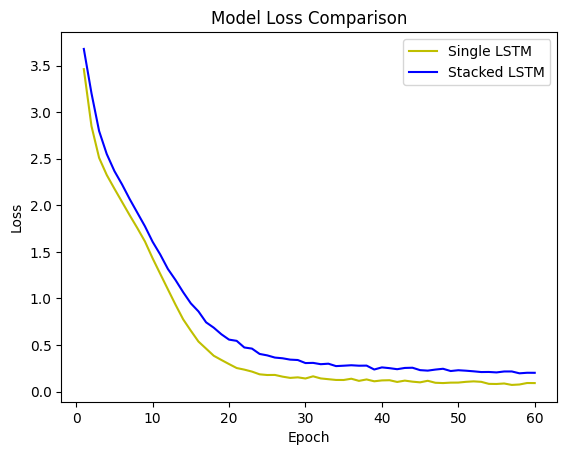

In [19]:
import matplotlib.pyplot as plt

# Single LSTM model loss
loss_single_lstm = history.history['loss']
epochs_single_lstm = range(1, len(loss_single_lstm) + 1)

# Stacked LSTM model loss
loss_stacked_lstm = history2.history['loss']
epochs_stacked_lstm = range(1, len(loss_stacked_lstm) + 1)

# Create a plot of the loss for both models
plt.plot(epochs_single_lstm, loss_single_lstm, 'y', label='Single LSTM')
plt.plot(epochs_stacked_lstm, loss_stacked_lstm, 'b', label='Stacked LSTM')
plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()